## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [1]:
!wget -P /workspace/homework/04-evaluation \
    https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-03 12:26:12--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘/workspace/homework/04-evaluation/data.csv.7’

data.csv.7            0%[                    ]       0  --.-KB/s               

data.csv.7          100%[===================>]   1.41M  --.-KB/s    in 0.1s    

2023-10-03 12:26:13 (10.1 MB/s) - ‘/workspace/homework/04-evaluation/data.csv.7’ saved [1475504/1475504]



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [3]:
random_state=1
use_cols = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP",
]

df = pd.read_csv("/workspace/homework/04-evaluation/data.csv", usecols=use_cols)
#df.rename(columns={"MSRP": "Price"}, inplace=True)
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [4]:
# rename columns
df.columns = df.columns.str.lower().str.replace(" ", "_")   
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [5]:
# display columns with missing values
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [6]:
# fillna with zeros and check if there are any missing values
df.fillna(0, inplace=True)
df.isnull().sum().any()

False

In [7]:
# make price binary for > average price
target_cols = ["above_average", "price"]
df.rename(columns={'msrp': 'price'}, inplace=True)
df["above_average"] = (df.price > df.price.mean()).astype(int)
df.head()


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [8]:
print(random_state)
frac_train = 0.6
frac_val = 0.2
frac_test = 0.2
df_train_full, df_test = train_test_split(
    df, test_size=frac_test, shuffle=True, random_state=random_state)
df_train, df_val = train_test_split(
    df_train_full, test_size=frac_val/(frac_train+frac_val), shuffle=True, random_state=random_state)
display(df_train.head())
print(df_train.shape[0]/df.shape[0], df_val.shape[0]/df.shape[0], df_test.shape[0]/df.shape[0])

1


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
5727,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27,50485,1
5814,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18,26840,0
8450,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19,36490,0
2396,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17,43575,1
5494,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17,22595,0


0.5999664260533826 0.2000167869733087 0.2000167869733087


In [9]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27,50485,1
1,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18,26840,0
2,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19,36490,0
3,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17,43575,1
4,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17,22595,0


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [10]:
column_numerical = df_train.select_dtypes(include='number').columns.to_list()
column_numerical.remove('above_average')
column_numerical.remove('price')
column_numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [11]:
corr_matrix = df_train[column_numerical].corr().abs()
corr_matrix.values[np.tri(*corr_matrix.shape, dtype=bool).T] = np.nan
corr_matrix.style.background_gradient(cmap='seismic', vmin=-1, vmax=1)

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg
year,nan,nan,nan,nan,nan
engine_hp,0.335816,nan,nan,nan,nan
engine_cylinders,0.039037,0.778392,nan,nan,nan
highway_mpg,0.251888,0.400652,0.593152,nan,nan
city_mpg,0.199739,0.422814,0.584739,0.857892,nan


In [16]:
auc_scores = {}
for col_num in column_numerical:
    auc = roc_auc_score(df_train['above_average'], df_train[col_num])
    if auc < 0.5:
        auc = roc_auc_score(df_train['above_average'], -df_train[col_num])
    auc_scores[col_num] = auc

auc_scores = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['auc_score'])
auc_scores.loc[[
    "engine_hp",
    "engine_cylinders",
    "highway_mpg",
    "city_mpg",]].sort_values(by='auc_score', ascending=False)

,auc_score
engine_hp,0.917103
engine_cylinders,0.766116
city_mpg,0.673424
highway_mpg,0.633059


### Answer 1
`engine_hp`

---

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [24]:
# Training the model
# From now on, use these columns only:
# ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

# Apply one-hot-encoding using DictVectorizer
# and train the logistic regression with these parameters:
# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# What's the AUC of this model on the validation dataset? (round to the nearest thousandth)

targets = ['price', 'above_average']
dv = DictVectorizer(sparse=False)
train_dict = df_train.drop(columns=targets).to_dict(orient='records')
val_dict = df_val.drop(columns=targets).to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
y_train = df_train['above_average'].copy().values
y_val = df_val['above_average'].copy().values

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
np.round(auc, 3)

0.977

### Answer 2
`0.979`

---

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

/tmp/ipykernel_14/3592810898.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))


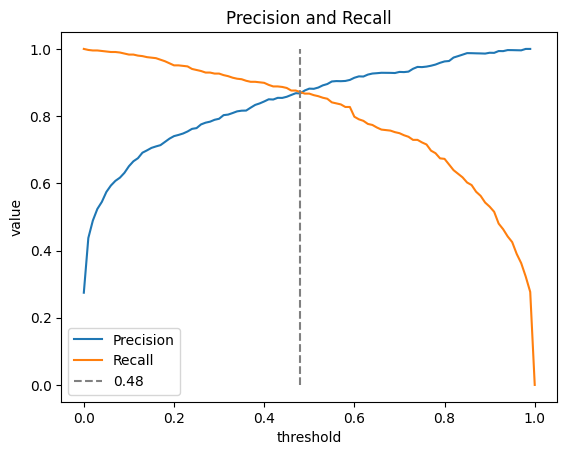

In [27]:
thresholds = np.linspace(0, 1, int(1/0.01+1))

precisions = []
recalls = []
for threshold in thresholds:
    actual_positive = (df_val['above_average'] == 1)
    actual_negative = (df_val['above_average'] == 0)
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()
    precisions.append(tp / (tp + fp))
    recalls.append(tp / (tp + fn))

df_pr = pd.DataFrame({'Precision': precisions, 'Recall': recalls}, index=thresholds)
ax = df_pr.plot(y=['Precision', 'Recall'], xlabel='threshold', ylabel='value', title='Precision and Recall')

# values of df_pr['Precision] and df['Recall] are not close, but both intersect inbetween values, how can i find out
# the exact values of the intersection?
idx = (df_pr['Precision'] - df_pr['Recall']).abs().idxmin()
ax.vlines(
    idx,
    ymin=0, ymax=1, linestyles='dashed', colors='grey',
    label=idx
)
ax.legend()

# Answer 3
`0.48`

---

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [28]:
df_pr["F1"] = 2 * df_pr['Precision'] * df_pr['Recall'] / (df_pr['Precision'] + df_pr['Recall'])
df_pr["F1"].idxmax().round(2)

0.5

In [29]:
# dipslay the f1_scores for index values between 0.49 and 0.51
df_pr.loc[0.48:0.52].round(3)

,Precision,Recall,F1
0.48,0.868,0.872,0.870
0.49,0.876,0.867,0.872
0.50,0.882,0.867,0.874
0.51,0.881,0.862,0.872
0.52,0.885,0.859,0.872


In [30]:
df_pr.loc[0.49:0.51].round(3)

,Precision,Recall,F1
0.49,0.876,0.867,0.872
0.50,0.882,0.867,0.874
0.51,0.881,0.862,0.872


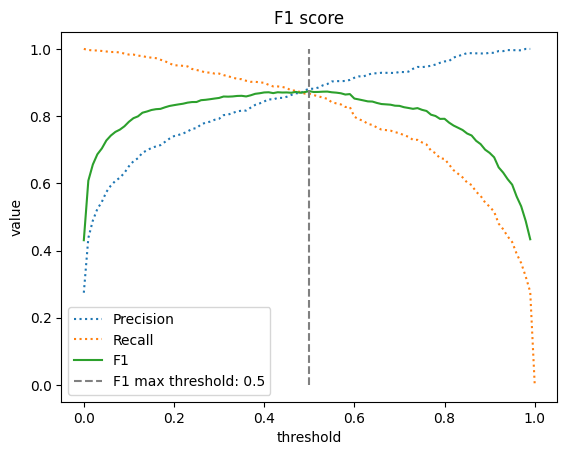

In [38]:
# plot the f1 of the dataframe
ax = df_pr.plot(y=['Precision', 'Recall'], xlabel='threshold', ylabel='value', linestyle=':')
ax = df_pr.plot(ax=ax, y='F1', label='F1', xlabel='threshold', ylabel='value', title='F1 score')
ax.vlines(
    df_pr.F1.idxmax(),
    ymin=0, ymax=1, linestyles='dashed', colors='grey',
    label=f"F1 max threshold: {df_pr.F1.idxmax().round(2)}"
)
ax.legend()

### Answer 4
`0.52`

---

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [39]:
def train(df_train_, y_train, C=1.0):
    dv = DictVectorizer(sparse=True)
    train_dict = df_train_.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df_val_, dv, model):
    val_dict = df_val_.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)
    return y_pred, y_pred_proba


In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

kf = KFold(n_splits=5, shuffle=True, random_state=1)
targets = ['price', 'above_average']
results = []

for train_idx, val_idx in kf.split(df_train_full):
    df_train_ = df_train_full.iloc[train_idx]
    df_val_ = df_train_full.iloc[val_idx]
    dv, model = train(df_train_.drop(columns=targets), df_train_.above_average)
    y_val = df_val_.above_average.values
    y_pred, y_pred_proba = predict(df_val_.drop(columns=targets), dv, model)

    auc = roc_auc_score(y_val, y_pred_proba)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    results.append({'AUC': auc, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})


# create a DataFrame from the results
df_results = pd.DataFrame(results)

# sort the results by AUC score
df_results = df_results.sort_values(by='AUC', ascending=False)

print(df_results)

        AUC  Accuracy  Precision    Recall        F1
2  0.984882  0.951207   0.925553  0.891473  0.908193
1  0.980740  0.937041   0.911290  0.856061  0.882812
3  0.979739  0.933368   0.896130  0.852713  0.873883
0  0.978479  0.934452   0.882129  0.880455  0.881292
4  0.977656  0.921301   0.854406  0.857692  0.856046


In [42]:
# add the std of the results
df_results.std().round(3)


AUC          0.003
Accuracy     0.011
Precision    0.027
Recall       0.017
F1           0.019
dtype: float64

### Answer 5
`0.003`

---

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [43]:

kf = KFold(n_splits=5, shuffle=True, random_state=1)
c_values = [0.01, 0.1, 0.5, 10]
results = []
for c in c_values:
    for train_idx, val_idx in kf.split(df_train_full):
        df_train_ = df_train_full.iloc[train_idx]
        df_val_ = df_train_full.iloc[val_idx]
        dv, model = train(df_train_.drop(columns=targets), df_train_.above_average, C=c)
        y_val = df_val_.above_average.values
        y_pred, y_pred_proba = predict(df_val_.drop(columns=targets), dv, model)

        auc = roc_auc_score(y_val, y_pred_proba)
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        results.append({'C': c, 'AUC': auc, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})

# create a DataFrame from the results
df_results = pd.DataFrame(results)

# sort the results by AUC score
df_results = df_results.sort_values(by='AUC', ascending=False)

print(df_results)

        C       AUC  Accuracy  Precision    Recall        F1
19  10.00  0.987310  0.950157   0.915851  0.900000  0.907856
17  10.00  0.984280  0.952781   0.926000  0.897287  0.911417
15  10.00  0.983178  0.949135   0.911877  0.903226  0.907531
16  10.00  0.980261  0.932844   0.901606  0.850379  0.875244
18  10.00  0.979623  0.937566   0.905930  0.858527  0.881592
12   0.50  0.978173  0.933893   0.907950  0.841085  0.873239
13   0.50  0.977727  0.926548   0.883673  0.839147  0.860835
14   0.50  0.977711  0.923400   0.862403  0.855769  0.859073
11   0.50  0.977031  0.927597   0.891566  0.840909  0.865497
10   0.50  0.974816  0.928684   0.875240  0.865275  0.870229
7    0.10  0.974003  0.931270   0.908705  0.829457  0.867275
9    0.10  0.973378  0.919203   0.873469  0.823077  0.847525
8    0.10  0.971091  0.921301   0.896104  0.802326  0.846626
5    0.10  0.970466  0.919245   0.876768  0.823529  0.849315
6    0.10  0.970056  0.914481   0.882600  0.797348  0.837811
0    0.01  0.955562  0.8

In [44]:
# group by C and aggregate the results by mean
df_grouped = df_results.groupby('C').mean()
# add the std of the results
df_grouped['AUC_std'] = df_results.groupby('C').std()['AUC'].round(3)
df_grouped['AUC_mean'] = df_results.groupby('C').mean()['AUC'].round(3)
# sort columns alphabetically
df_grouped = df_grouped.sort_index(axis=1)
# sort the results by AUC score
df_grouped.sort_values(by='AUC_mean', ascending=False)

,AUC,AUC_mean,AUC_std,Accuracy,F1,Precision,Recall
C,,,,,,,
10.00,0.982930,0.983,0.003,0.944496,0.896728,0.912253,0.881884
0.50,0.977092,0.977,0.001,0.928024,0.865775,0.884167,0.848437
0.10,0.971799,0.972,0.002,0.921100,0.849710,0.887529,0.815148
0.01,0.951586,0.952,0.003,0.890148,0.786567,0.839607,0.739907


### Answer 6
`10.0`

---

## Submit the results

- Submit your results here: https://forms.gle/E7Fa3WuBw3HkPQYg6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 9 (Monday), 23:00 CET. After that the form will be closed.